# Capstone Project Data Wrangling
*Kimberly Kaufman*  
*June 15, 2019*
  
---

### Introduction

The following steps were taken to clean and wrangle one year's worth of outbound distribution and freight cost data related to Wiley's North American distribution center. This data has been extracted from a combination of proprietary relational database systems (via SQL) and archived csv files of monthly freight bills. The full dataset will be used to predict the future freight costs of physical book fulfillment through a supervised machine learning approach.

For more details on this project, see the <a href="https://github.com/kaufkauf/Capstone-Project-Intermediate">GitHub repository</a>.

### Data Structure

The data for this project is available as 5 separate csv files.  Four of these files contain 3 months' each (or four quarters' total) worth of outbound volume data (read in below as "vol") and the fifth csv file contains 12 months' worth of freight cost data from Wiley's 3PL provider (read in below as "freight").  Both the consolidated volume and freight datasets represent the same 12 month time period of ship verify and 3PL interface dates, respectively, for May 2018 through April 2019 (as this represents Wiley's fiscal reporting year).

In [39]:
import pandas as pd
import numpy as np

# set working directory & read in files
wd = 'C:/Users/kkaufman/Documents/Data Sci/Intermediate/Freight model/'
vol1 = pd.read_csv(wd + 'FY19outboundv2 - Q1.csv', low_memory=False)
vol2 = pd.read_csv(wd + 'FY19outboundv2 - Q2.csv', low_memory=False)
vol3 = pd.read_csv(wd + 'FY19outboundv2 - Q3.csv', low_memory=False)
vol4 = pd.read_csv(wd + 'FY19outboundv2 - Q4.csv', low_memory=False)
vol = vol1.append([vol2,vol3,vol4])
freight = pd.read_csv(wd + 'FY19freightcharges.csv', low_memory=False) 

# print the summary information for each data frame
print(vol.info())
print(freight.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1131645 entries, 0 to 280156
Data columns (total 22 columns):
CJDAT1                1131645 non-null int64
IHINDT                1131645 non-null int64
IHAEDT                1131645 non-null int64
INVOICENO             1131645 non-null int64
ISBN10                1131645 non-null object
PRODUCT_LINE          1131645 non-null object
GLOBAL_BUSINESS       1131645 non-null object
BOOK_WEIGHT           1131645 non-null float64
COLLECT_METHOD        1131645 non-null object
CARRIER_CODE          1131645 non-null object
PRIORITY_CODE         1131645 non-null object
SHIP_METHOD           1131645 non-null object
FREIGHT_TYPE          1048609 non-null object
SHIP_COUNTRY_NAME     1131632 non-null object
MARKET_OUTLET         1131645 non-null int64
BATCH_NO              1131645 non-null object
CARTON_QTY            1131645 non-null int64
CARTONS_PER_PALLET    1131645 non-null int64
TOTAL_UNITS           1131645 non-null int64
TOTAL_LOOSE          

Note that each dataset has been read in as a Pandas data frame.  Our consolidated volume data frame contains 22 variables and 1,131,645 observations, whereas our freight data frame contains 7 variables and 129,822 observations.  These shapes are relatively normal for a couple of reasons: first, the freight charges have been rolled up to the invoice level whereas the volume information is at a line level detail; second, not all of our outbound volume incurs freight cost to Wiley. So, we would expect our volume data to have many more observations than our freight data.

The join keys for these two data frames will be the 3PL interface date (represented by CJDAT1 in vol and by INTDATE in freight) and the invoice number (represented by INVOICENO in vol and by INVNUMBER in freight).  *Note that invoice date functions differently in each dataset and cannot be used as a join key.*

At the end of our data wrangling, we will need to roll up the volume dataset to an invoice level before joining in the freight cost data, as it is not correct to assume the freight cost for each invoice splits evenly among each line.


### Data Types

The attributes of the volume dataset include:
* 3 Product description variables
    + ISBN10, product line, global business (categorical; object)
* 13 Invoice level variables
    + Invoice date (IHINDT), 3PL interface date (CJDAT1), ship verify date (IHAEDT) (continuous; integer)
    + Invoice number (continuous; integer)
    + Batch number (categorical; object)
    + Carton quantity, cartons per pallet (continuous; integer)
    + Outbound units, outbound loose, outbound cartons, outbound pallets (continuous; integer)
    + Book weight (continuous; float)
* 2 Customer demographic variables
    + Market outlet, customer destination (categorical; object)
* 4 Transportion variables
    + Ship method, freight type, priority code, carrier code, collect y/n (categorical; object)
    
The attributes of the freight dataset include:
* 1 Product description variables
    + Product group (categorical)
* 5 Invoice level variables
    + Invoice date (INVDATE), 3PL interface date (INTDATE), billing date (BILLDATE) (continuous; integer)
    + Invoice number (INVNUMBER) (continuous; integer)
    + Shipment weight (continuous; float)
* 1 Output variable / target
    + Total charge (continuous; float)
    
For the purposes of EDA and data wrangling, both of these datasets have been read in with the correct data types.  It is possible that when it is time to fit the model, we will need to convert our "collect y/n" field in the volume dataset to a binary 1/0, but this determination can be made later down the line.

### Missing Values

Luckily, the majority of the variables in both datasets are absent of missing values.  See below for a count of non-null observations to give a sense of this completeness.

In [7]:
# print a count of non-null values
print(vol.count())
print(freight.count())

CJDAT1                1131645
IHINDT                1131645
IHAEDT                1131645
INVOICENO             1131645
ISBN10                1131645
PRODUCT_LINE          1131645
GLOBAL_BUSINESS       1131645
BOOK_WEIGHT           1131645
COLLECT_METHOD        1131645
CARRIER_CODE          1131645
PRIORITY_CODE         1131645
SHIP_METHOD           1131645
FREIGHT_TYPE          1048609
SHIP_COUNTRY_NAME     1131632
MARKET_OUTLET         1131645
BATCH_NO              1131645
CARTON_QTY            1131645
CARTONS_PER_PALLET    1131645
TOTAL_UNITS           1131645
TOTAL_LOOSE           1131645
TOTAL_CARTONS         1131645
TOTAL_PALLETS         1131645
dtype: int64
INVNUMBER      129822
BILLDATE       129822
INVDATE        129822
INTDATE        129822
PRODGRP        126313
SHIPWEIGHT     129822
TOTALCHARGE    129822
dtype: int64


We can see that our volume data is almost entirely clean aside from some missing values in the "freight type" variable.  Our freight type variable has approximately 83,000 null values, which represents about 7% of the total dataset.  We can refresh ourselves on the meaning of the freight type variable by taking a look at its unique values below.

In [8]:
print(vol['FREIGHT_TYPE'].unique())

['Domestic Ground Small Package ' 'Customer Pick Up              '
 'GTW Ground Small Package      ' 'Subsidiary Ship Methods       ' nan
 'GTW Ground Freight            ' 'Domestic Ground Freight       '
 "Int'l Air Courier             " 'Domestic Air Courier          '
 'GTW Air Courier               ' "Int'l Surface                 "
 'Domestic Air Freight          ']


Since there is no immediately reliable way to make an assumption on what these missing values might be, we can impute them with a placeholder variable of "Unknown."  It is also evident that the non-null freight type variables have a number of trailing spaces attached to the string, so we'll want to strip those spaces from the variable as well.

In [9]:
vol['FREIGHT_TYPE'] = vol['FREIGHT_TYPE'].str.strip().fillna('Unknown')
print(vol['FREIGHT_TYPE'].count())
print(vol['FREIGHT_TYPE'].unique())

1131645
['Domestic Ground Small Package' 'Customer Pick Up'
 'GTW Ground Small Package' 'Subsidiary Ship Methods' 'Unknown'
 'GTW Ground Freight' 'Domestic Ground Freight' "Int'l Air Courier"
 'Domestic Air Courier' 'GTW Air Courier' "Int'l Surface"
 'Domestic Air Freight']


In addition to the missing freight type values, there are also exactly 13 missing values in our "Ship Country Name" field, which are negligible.  See below for the unique values of our Ship Country Name variable.

In [10]:
print(vol['SHIP_COUNTRY_NAME'].unique())

['UNITED STATES                 ' 'CANADA                        '
 'UNITED KINGDOM                ' 'JAPAN                         '
 'AUSTRALIA                     ' 'SINGAPORE                     '
 'BRAZIL                        ' 'MALAYSIA                      '
 'CHINA                         ' 'TAIWAN                        '
 'INDIA                         ' 'ANTIGUA & BARBUDA             '
 'SWEDEN                        ' 'FOREIGN PURCHASE  (USA)       '
 'SOUTH KOREA                   ' 'NETHERLANDS                   '
 'CHILE                         ' 'PHILIPPINES                   '
 'BELGIUM                       ' 'ITALY                         '
 'FRANCE                        ' 'MEXICO                        '
 'POLAND                        ' 'GERMANY                       '
 'ARGENTINA                     ' 'SWITZERLAND                   '
 'VIETNAM                       ' 'PERU                          '
 'COLOMBIA                      ' 'GREECE                     

We may be able to derive the Ship Country Name from other variables as we get to know our data better.  In the meantime, we'll treat it similarly to freight type and impute the missing values with "Unknown."  Since we can also see that the cases of the characters in the strings are inconsistent (see: "Northern Mariana Islands") and there are trailing spaces at the end, we'll want to clean up the non-null values as well.

In [11]:
vol['SHIP_COUNTRY_NAME'] = vol['SHIP_COUNTRY_NAME'].str.title().str.strip().fillna('Unknown')
vol['SHIP_METHOD'] = vol['SHIP_METHOD'].str.strip()
print(vol['SHIP_COUNTRY_NAME'].unique())

['United States' 'Canada' 'United Kingdom' 'Japan' 'Australia' 'Singapore'
 'Brazil' 'Malaysia' 'China' 'Taiwan' 'India' 'Antigua & Barbuda' 'Sweden'
 'Foreign Purchase  (Usa)' 'South Korea' 'Netherlands' 'Chile'
 'Philippines' 'Belgium' 'Italy' 'France' 'Mexico' 'Poland' 'Germany'
 'Argentina' 'Switzerland' 'Vietnam' 'Peru' 'Colombia' 'Greece' 'Romania'
 'Indonesia' 'Denmark' 'Panama' 'Russia' 'South Africa' 'Thailand'
 'Kuwait' 'Egypt' 'Austria' 'Hong Kong' 'Virgin Islands (Us)'
 'Czech Republic' 'Jamaica' 'Kazakhstan' 'Guam' 'Spain' 'Puerto Rico'
 'New Zealand' 'Pakistan' 'Venezuela' 'Trinidad And Tobago' 'Ireland'
 'Slovenia' 'Saudi Arabia' 'Unknown' 'Barbados' 'Tanzania' 'Cyprus'
 'Finland' 'Portugal' 'Israel' 'Macedonia' 'Uruguay' 'Jordan' 'Turkey'
 'Algeria' 'Qatar' 'United Arab Emirates' 'Norway' 'Costa Rica' 'Kenya'
 'Bermuda' 'Cambodia' 'Croatia' 'Curacao' 'Cayman Islands' 'Bahamas'
 'Ghana' 'Ecuador' 'Iran' 'Bahrain' 'Saint Kitts And Nevis' 'Libya'
 'Latvia' 'Estonia' 'Us Mi

Note that other text string fields in the volume dataset, such as "Ship Method," have been cleansed of trailing spaces as well.

Our freight dataset is entirely absent of missing values aside from the "Product Group" field.  "Product Group" is a 3PL created identifier that distinguishes between our test prep product and non-test prep product, but has only been implemented as a field several months ago (hence the null values).  Due to the incomplete nature of this field as well as the fact that it is a redundant variable (it is repeated in more detail by the "Global Business" field in the volume dataset), we can safely assume this field will not be used in the model and that it can therefore be left alone in terms of missing value treatment.

### Outliers

Outlier treatment for these datasets will depend on the statistical summary of our variables.  See below for summary stats on each variable.

In [12]:
print(vol.loc[:,['BOOK_WEIGHT','TOTAL_PALLETS','TOTAL_CARTONS','TOTAL_LOOSE','TOTAL_UNITS']].describe())
print(freight.iloc[:,5:7].describe())

        BOOK_WEIGHT  TOTAL_PALLETS  TOTAL_CARTONS   TOTAL_LOOSE   TOTAL_UNITS
count  1.131645e+06   1.131645e+06   1.131645e+06  1.131645e+06  1.131645e+06
mean   2.902273e+01   2.301959e-03   4.131746e-01  2.593339e+00  1.126777e+01
std    2.730440e+01   1.700169e-01   2.357927e+00  5.239535e+00  1.130221e+02
min    0.000000e+00   0.000000e+00   0.000000e+00  0.000000e+00  0.000000e+00
25%    1.600000e+01   0.000000e+00   0.000000e+00  1.000000e+00  1.000000e+00
50%    2.080000e+01   0.000000e+00   0.000000e+00  1.000000e+00  1.000000e+00
75%    3.760000e+01   0.000000e+00   0.000000e+00  2.000000e+00  4.000000e+00
max    9.037440e+03   8.600000e+01   1.200000e+02  2.400000e+03  3.825400e+04
          SHIPWEIGHT    TOTALCHARGE
count  129822.000000  129822.000000
mean       36.403733      15.069798
std       664.402469      56.250573
min         0.000000    -241.040000
25%         2.200000       5.071500
50%         3.600000       6.980500
75%         7.000000       9.982000
max     90

For all continuous variables that are meant to function as numbers rather than identifiers (e.g. all continuous variables aside from invoice number and dates), distributions of data have been checked for outliers.  Although it cannot necessarily be intuited from the summary statistics, several of these variables have noticeable outliers.

One of these variables is book weight, which appears to have a few (3) outliers above 8,000 ounces.  We can also see that 11,523 values are equal to zero, which should not be the case for a physical item.  For this variable, we will want to take a capping/flooring approach to outlier handling by imputing all low and high outliers with the 5th/95th percentiles, respectively.

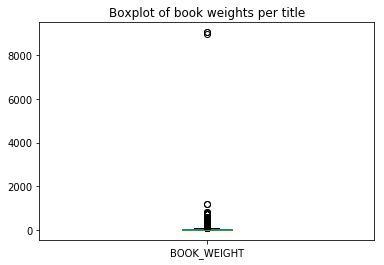

Book weight by percentile
0.00       0.00
0.05       6.88
0.10      10.40
0.20      14.40
0.30      16.80
0.40      18.40
0.50      20.80
0.60      25.60
0.70      32.80
0.80      44.00
0.90      53.60
0.95      68.80
1.00    9037.44
Name: BOOK_WEIGHT, dtype: float64
Book weight outliers > 8,000 and equal to 0
3
11523


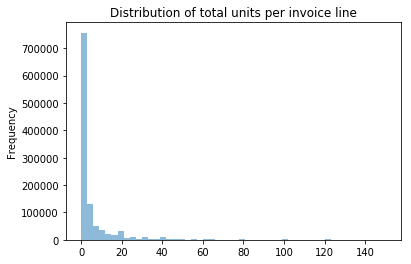

In [45]:
import matplotlib.pyplot as plt
vol['BOOK_WEIGHT'].plot(kind= 'box',title='Boxplot of book weights per title')
plt.show()
print('Book weight by percentile')
print(vol['BOOK_WEIGHT'].quantile([0,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,1]))
print('Book weight outliers > 8,000 and equal to 0')
print((vol.loc[vol['BOOK_WEIGHT']>8000])['BOOK_WEIGHT'].count())
print((vol.loc[vol['BOOK_WEIGHT']==0])['BOOK_WEIGHT'].count())

vol['TOTAL_UNITS'].plot(kind= 'hist', bins=50, range=(0,150), alpha=0.5, title='Distribution of total units per invoice line')
plt.show()

In addition to book weight, we also have to check for outliers in our total units, total loose, total cartons, and total pallets fields.  It is worth noting that we will not be inspecting our carton quantity or cartons per pallet fields, since those fields cannot be aggregated to an invoice level and mainly exist to calculate cartons and pallets for each line.

Although there are some zeroes in our pallets, cartons, and loose fields, this is normal and to be expected when translating unit numbers into pallets, cartons, and loose based on their dimensions.  There should not be zeroes in our total units column, but since this only represents 9 observations, it should be okay to leave them in the dataset.

The same conclusion can be made for our outliers on the high side (above the 95th percentile).  Although these numbers are quite high, they do represent legitimately large shipments, and should therefore not be altered.

In [43]:
print(vol[['TOTAL_PALLETS','TOTAL_CARTONS','TOTAL_LOOSE','TOTAL_UNITS']].quantile([0,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,1]))

      TOTAL_PALLETS  TOTAL_CARTONS  TOTAL_LOOSE  TOTAL_UNITS
0.00            0.0            0.0          0.0          0.0
0.05            0.0            0.0          0.0          1.0
0.10            0.0            0.0          1.0          1.0
0.20            0.0            0.0          1.0          1.0
0.30            0.0            0.0          1.0          1.0
0.40            0.0            0.0          1.0          1.0
0.50            0.0            0.0          1.0          1.0
0.60            0.0            0.0          1.0          2.0
0.70            0.0            0.0          2.0          3.0
0.80            0.0            0.0          3.0          6.0
0.90            0.0            1.0          6.0         20.0
0.95            0.0            2.0         10.0         36.0
1.00           86.0          120.0       2400.0      38254.0


In [15]:
# impute book weight outliers with 5th/95th percentiles
vol['BOOK_WEIGHT'] = np.where(vol['BOOK_WEIGHT'] < vol['BOOK_WEIGHT'].quantile(.05), vol['BOOK_WEIGHT'].quantile(.05), vol['BOOK_WEIGHT'])
vol['BOOK_WEIGHT'] = np.where(vol['BOOK_WEIGHT'] > vol['BOOK_WEIGHT'].quantile(.95), vol['BOOK_WEIGHT'].quantile(.95), vol['BOOK_WEIGHT'])
print(vol['BOOK_WEIGHT'].describe())

count    1.131645e+06
mean     2.777711e+01
std      1.706760e+01
min      6.880000e+00
25%      1.600000e+01
50%      2.080000e+01
75%      3.760000e+01
max      6.880000e+01
Name: BOOK_WEIGHT, dtype: float64


### Merging the Datasets

Now that the data has been cleaned and checked for outliers, the volume data must be rolled up to an invoice level and then joined to the freight data.  We will do this by grouping by our invoice numbers, interface dates, and categorical variables, and then summarizing the continuous volume variables such as total lines, units, loose units, cartons, pallets, and weight before joining to the freight charge data.

One slight complication to our volume data involves categorizing invoices by the owner of the product.  In this dataset, we have 31,165 unique ISBN10s, each of which rolls up to 71 unique product lines that indicate the type of product (Dummies books, Chemistry textbooks, etc) and each of these product lines rolls up to one of 5 global businesses (Trade, Education, Reference, Test Prep, and Agency).  Due to the fact that we regularly ship orders with multiple types of product in one shipment, we cannot necessarily allocate a single global business to each invoice.

In order to accommodate this global business variable at an invoice level, we will pivot our total lines, units, loose, cartons, and pallets by global business, which widens our dataset whilst still preserving the information related to the product owner.

In [50]:
# pivot volume data based on invoice number & convert to dataframe
idxcols = ['CJDAT1','IHINDT','IHAEDT','INVOICENO','COLLECT_METHOD','CARRIER_CODE','PRIORITY_CODE','SHIP_METHOD','FREIGHT_TYPE','SHIP_COUNTRY_NAME','MARKET_OUTLET']
valcols = ['ISBN10','TOTAL_UNITS','TOTAL_PALLETS','TOTAL_CARTONS','TOTAL_LOOSE','BOOK_WEIGHT']
dfvol = pd.pivot_table(vol, index=idxcols, columns=['GLOBAL_BUSINESS'], values=valcols, 
                       aggfunc={('ISBN10') : len,
                                ('TOTAL_UNITS') : sum,
                                ('TOTAL_PALLETS') : sum,
                                ('TOTAL_CARTONS') : sum,
                                ('TOTAL_LOOSE') : sum,
                                ('BOOK_WEIGHT') : sum}, 
                                fill_value=0)
dfvol = pd.DataFrame(dfvol)
dfvol.reset_index(inplace=True)

# remove multilevel column index & replace with concatenated column names using list comprehension
cols = [str.strip(str.replace((key + ' ' + value),'ISBN10','TOTAL_LINES')) for key, value in dfvol.columns]
dfvol.columns = dfvol.columns.get_level_values(0)
dfvol.columns = cols

# add columns for carton weight & totals
dfvol['CARTON_WEIGHT Agency'] = dfvol['BOOK_WEIGHT Agency']*dfvol['TOTAL_UNITS Agency']
dfvol['CARTON_WEIGHT Education'] = dfvol['BOOK_WEIGHT Education']*dfvol['TOTAL_UNITS Education']
dfvol['CARTON_WEIGHT Reference'] = dfvol['BOOK_WEIGHT Reference']*dfvol['TOTAL_UNITS Reference']
dfvol['CARTON_WEIGHT Test Prep'] = dfvol['BOOK_WEIGHT Test Prep']*dfvol['TOTAL_UNITS Test Prep']
dfvol['CARTON_WEIGHT Trade'] = dfvol['BOOK_WEIGHT Trade']*dfvol['TOTAL_UNITS Trade']
dfvol['TOTAL CARTONS Total'] = dfvol['TOTAL_CARTONS Agency']+dfvol['TOTAL_CARTONS Education']+dfvol['TOTAL_CARTONS Reference']+dfvol['TOTAL_CARTONS Test Prep']+dfvol['TOTAL_CARTONS Trade']
dfvol['TOTAL LOOSE Total'] = dfvol['TOTAL_LOOSE Agency']+dfvol['TOTAL_LOOSE Education']+dfvol['TOTAL_LOOSE Reference']+dfvol['TOTAL_LOOSE Test Prep']+dfvol['TOTAL_LOOSE Trade']
dfvol['TOTAL PALLETS Total']= dfvol['TOTAL_PALLETS Agency']+dfvol['TOTAL_PALLETS Education']+dfvol['TOTAL_PALLETS Reference']+dfvol['TOTAL_PALLETS Test Prep']+dfvol['TOTAL_PALLETS Trade']
dfvol['TOTAL UNITS Total'] = dfvol['TOTAL_UNITS Agency']+dfvol['TOTAL_UNITS Education']+dfvol['TOTAL_UNITS Reference']+dfvol['TOTAL_UNITS Test Prep']+dfvol['TOTAL_UNITS Trade']
dfvol['CARTON_WEIGHT Total'] = dfvol['CARTON_WEIGHT Agency']+dfvol['CARTON_WEIGHT Education']+dfvol['CARTON_WEIGHT Reference']+dfvol['CARTON_WEIGHT Test Prep']+dfvol['CARTON_WEIGHT Trade']

Now that we have widened our volume dataset and rolled it up to an invoice level, we'll be joining it to the freight dataset on the invoice number and interface date fields.  This can be achieved with the Pandas merge function.

In [49]:
# join vol data to freight data
dffreight = freight[['INVNUMBER','INTDATE','TOTALCHARGE']]
df1 = pd.merge(left=dfvol, right=dffreight, how='left', left_on=['INVOICENO','CJDAT1'], right_on=['INVNUMBER','INTDATE'],copy=False)
df1['TOTALCHARGE'] = df1['TOTALCHARGE'].fillna(0)
df1 = df1.drop(columns=['INVNUMBER','INTDATE'],axis=1)

# view revised dataframe
print(dfvol.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412027 entries, 0 to 412026
Data columns (total 51 columns):
CJDAT1                     412027 non-null int64
IHINDT                     412027 non-null int64
IHAEDT                     412027 non-null int64
INVOICENO                  412027 non-null int64
COLLECT_METHOD             412027 non-null object
CARRIER_CODE               412027 non-null object
PRIORITY_CODE              412027 non-null object
SHIP_METHOD                412027 non-null object
FREIGHT_TYPE               412027 non-null object
SHIP_COUNTRY_NAME          412027 non-null object
MARKET_OUTLET              412027 non-null int64
BOOK_WEIGHT Agency         412027 non-null float64
BOOK_WEIGHT Education      412027 non-null float64
BOOK_WEIGHT Reference      412027 non-null float64
BOOK_WEIGHT Test Prep      412027 non-null float64
BOOK_WEIGHT Trade          412027 non-null float64
TOTAL_LINES Agency         412027 non-null int64
TOTAL_LINES Education      412027 non-nu

### Final Dataset

To review, we have used a combination of Pandas, Numpy, and Matplotlib to clean and wrangle our datasets into one final dataframe.  We read in our freight and volume data from 5 csv files, consolidated them into two files, and found our initial data types for each variable to be correctly interpreted by the read_csv function.  We found two variables to have a number of missing variables--the first of which (freight type) we replaced with a value of "Unknown," and the second we left alone as this variable was to be removed from the final dataset due to it being a redundant field.  We treated one variable (book weight) for outliers by taking a capping/flooring approach to imputing those values.  Finally, we pivoted our volume dataset by global business, added a number of subtotals, and rolled up to the invoice level before merging with our freight dataset to create one final dataframe for analysis (df1).